<h1 style="color: #001a79;">Machine Learning Project Notebook</h1>

<h3 style="color: #001a79;">For this notebook you will need the following packages:</h3>

In [49]:
# Efficient numerical arrays.
import numpy as np

# Dataframes for data manipulation and analysis.
import pandas as pd

# Neural networks.
import tensorflow.keras as keras

# Plotting.
import matplotlib.pyplot as plt

# Fancier plotting.
import seaborn as sns

# Plotting dates.
import matplotlib.dates as mdates

<h3 style="color: #001a79;">Introduction</h3>

<hr style="border-top: 1px solid #001a79;" />

Detecting anomalies in datasets has broad applications in a lot of domains. These include areas such as fraud detection in credit cards, fault detection and safety critical systems, and network intrusion detection for cyber secuirity. Due to it's wide range of appications the problem of anomaly detection has been thoroughly reseached amongst industry specialists and academics. Several algorithms have been introduced for determining anomalies in problem settings. However, there were no datasets or framework that was openly availible which the proposed algorithms could be evaluated on a common ground. This changed with the introduction of the Numenta Anomaly Benchmark (NAB) Framework in 2015.  

The Numenta Anomaly Benchmark (NAB) Framework is an open source framework with extensive documentation, and a scoreboard of anomaly detection algorithms found <a href="https://github.com/numenta/NAB" target="_blank">here</a>. used to evaluate and compare various anomaly detection algorithms. It contains labeled data files and a common scoring system to compare and evaluate different anomaly detection algorithms for detecting anomalies in streaming data. In streaming data, anomalies (which can also be refered to as outliers) are patterns that do not match with previous patterns of behaviour for the given data stream. 

The Numenta Anomaly Benchmark (NAB) has two major components. The labelled data sets which comprise of over 50 labeled real-world and artificial timeseries data files and the scoring system designed for real-time applications. Each has been designed to create a evaluation framework for various anomaly detection algotrithms. 

https://www.youtube.com/watch?v=QPQA9X5-V0g&ab_channel=fintelics

Comeback to

https://keras.io/examples/timeseries/timeseries_anomaly_detection/

<h3 style="color: #001a79;">Loading the Data</h3>

<hr style="border-top: 1px solid #001a79;" />

To demonstrate anomaly detection effectively we will use two datasets from the Numenta Anomaly Benchmark (NAB) Dataset. 

1. <a href="https://github.com/numenta/NAB/blob/master/data/artificialNoAnomaly/art_daily_small_noise.csv" target="_blank">`art_daily_small_noise.csv`</a> file for training.
2. <a href="https://github.com/numenta/NAB/blob/master/data/artificialWithAnomaly/art_daily_jumpsup.csv" target="_blank">`the art_daily_jumpsup.csv`</a> file for testing.

In [50]:
# These CSVs can be found at the follow URL.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'
root_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/'

### `df_train`

In [51]:
# art_daily_small_noise.csv data file url.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [52]:
# Import and save data as a df - df_small_noise. 
# parse_dates=True will tell pandas you are importing a date while index_col="timestamp" sets timestamp as the index. 
df_train = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

# Print 
df_train

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120
...,...
2014-04-14 23:35:00,20.211195
2014-04-14 23:40:00,20.531041
2014-04-14 23:45:00,19.032127


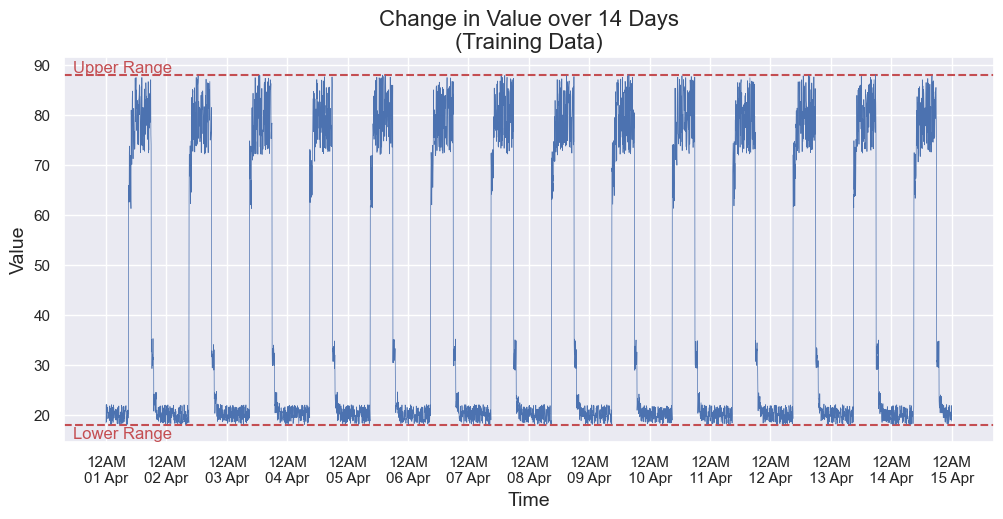

In [55]:
# Graph style
sns.set(style="darkgrid")

# Set figure size
fig, ax = plt.subplots(figsize=(12,5))

# Add title
plt.title("Change in Value over 14 Days\n(Training Data)", fontsize=16)

# Add x and y labels
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Define the date format
date_form = mdates.DateFormatter("12AM\n%d %b")
ax.xaxis.set_major_formatter(date_form)

# Set x-axis to 1 day intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Show red line at values range 
ax.axhline(y = 18, color = 'r', linestyle = '--')
ax.axhline(y = 88, color = 'r', linestyle = '--')

# Plot upper and lower range. 
plt.text(0.01, .96, 'Upper Range', color = 'r', transform=ax.transAxes)
plt.text(0.01, .01, 'Lower Range', color = 'r', transform=ax.transAxes)

# Plot Time vs Value
plt.plot(df_train.index, df_train['value'], linewidth=0.5);


https://matplotlib.org/stable/api/dates_api.html
https://www.youtube.com/watch?v=_LWjaAiKaf8&t=889s&ab_channel=CoreySchafer
https://stackoverflow.com/a/63281376
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html

<a href="https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/#:~:text=Using%20the%20DateFormatter%20module%20from,number%20with%20lower%20case%20m" target="_blank">Earth Lab: How to Reformat Date Labels in Matplotlib</a>

`df_small_noise` contains 4,032 rows of data with 2 columns `timestamp` (the index) and `value`. 

`timestamp` - Is the dataframes index and represents a **date and time** formatted as Year-Month-Day (YYYY-MM-DD) and Hours:Minutes:Seconds (hh:mm:ss). 

The timestamp starts at the 1st of April 2014 at 12:00am and increments by 5 minutes at each row. The last data point on 14th of April 2014 at 12:55pm. 

Therefore for 14 days, every 5 minutes a value is recorded. 
- Every hour 12 values are recorded. 
- Every day 288 values are recorded. 
- So in 14 days 4,032 values are recorded in total.

`value` - 

### `df_daily_jumpsup` 

In [6]:
# art_daily_jumpsup.csv data file url.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

# Import and save data as a df - df_daily_jumpsup. 
df_daily_jumpsup  = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

# Print 
df_daily_jumpsup

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


`df_daily_jumpsup` also contains 4,032 rows of data with 2 columns `timestamp` (the index) and `value`. 

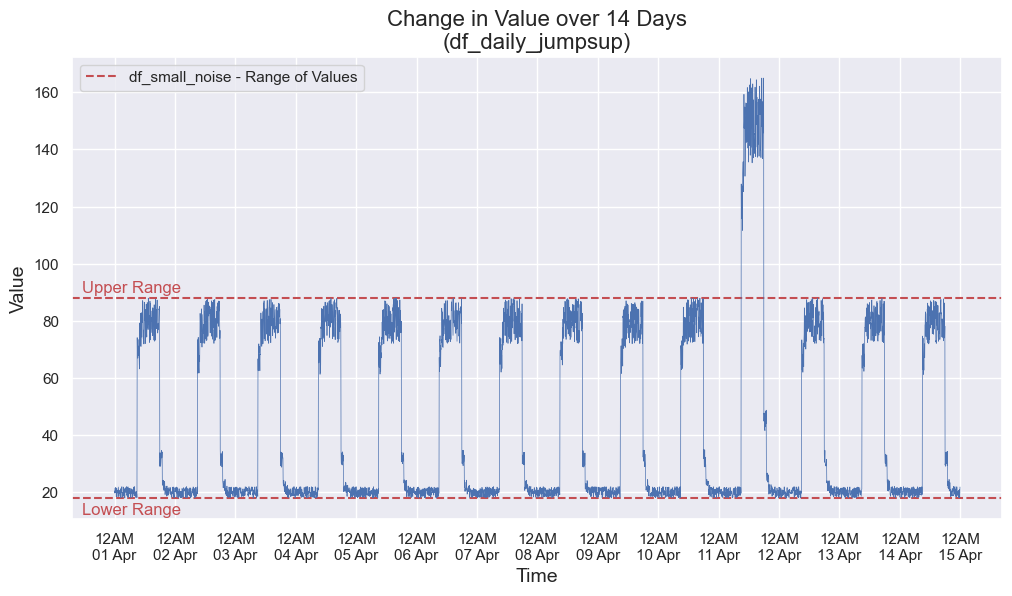

In [7]:
# Set figure size
fig, ax = plt.subplots(figsize=(12,6))

# Add title
plt.title("Change in Value over 14 Days\n(df_daily_jumpsup)", fontsize=16)

# Add x and y labels
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Define the date format
date_form = mdates.DateFormatter("12AM\n%d %b")
ax.xaxis.set_major_formatter(date_form)

# Set x-axis to 1 day intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Show red line at values range 
ax.axhline(y = 18, color = 'r', linestyle = '--', label = 'df_small_noise - Range of Values')
ax.axhline(y = 88, color = 'r', linestyle = '--')

# Legend
plt.legend()

# Plot upper and lower range. 
plt.text(0.01, .49, 'Upper Range', color = 'r', transform=ax.transAxes)
plt.text(0.01, .01, 'Lower Range', color = 'r', transform=ax.transAxes)

# Plot Time vs Value
plt.plot(df_daily_jumpsup.index, df_daily_jumpsup['value'], linewidth=0.5);

<h3 style="color: #001a79;">Preprocessing</h3>

<hr style="border-top: 1px solid #001a79;" />

### `df_small_noise`

In [8]:
# Calculate the mean of values
train_mean = df_small_noise['value'].mean()

# Calculate the standard deviation of values
train_std = df_small_noise['value'].std()

print(f'Mean: {train_mean:.2f}')
print(f'Standard Deviation: {train_std:.2f}')

Mean: 42.44
Standard Deviation: 28.08


In [9]:
# Normalise the data 
df_train_vals = (df_small_noise - train_mean) / train_std
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


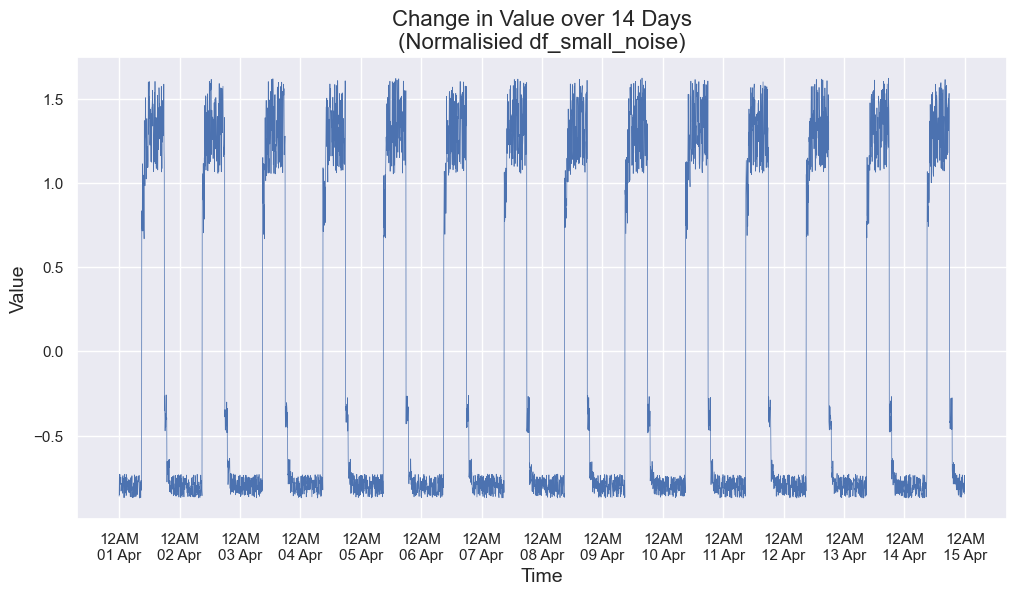

In [10]:
# Set figure size
fig, ax = plt.subplots(figsize=(12,6))

# Add title
plt.title("Change in Value over 14 Days\n(Normalisied df_small_noise)", fontsize=16)

# Add x and y labels
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Define the date format
date_form = mdates.DateFormatter("12AM\n%d %b")
ax.xaxis.set_major_formatter(date_form)

# Set x-axis to 1 day intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Plot Time vs Value
plt.plot(df_train_vals.index, df_train_vals['value'], linewidth=0.5);

As mentioned about, values were recorded for 14 days, every 5 minutes. Therefore: 
- Every hour 12 values are recorded. 
- Every day 288 values are recorded. 
- So in 14 days 4,032 values are recorded in total.

In [11]:
# The number of values recorded per day
day_size = 288

In [12]:
df_train_vals['value']

timestamp
2014-04-01 00:00:00   -0.858829
2014-04-01 00:05:00   -0.728993
2014-04-01 00:10:00   -0.848148
2014-04-01 00:15:00   -0.729586
2014-04-01 00:20:00   -0.731173
                         ...   
2014-04-14 23:35:00   -0.791647
2014-04-14 23:40:00   -0.780255
2014-04-14 23:45:00   -0.833640
2014-04-14 23:50:00   -0.735102
2014-04-14 23:55:00   -0.846089
Name: value, Length: 4032, dtype: float64

In [13]:
# Split 1D array into a 2D array of size N
def splitBySize(vals, N=day_size):
    # Empty list
    L = []
    # Loop through index 0 to the (length of vals - N + 1)
    for i in range(len(vals) - N + 1):
        # Separate vals into arrays of length N
        L.append(vals[i:i+N])
    # Stack these arrays to create a 2D array
    return np.stack(L)

In [14]:
x_train = splitBySize(df_train_vals)

In [15]:
print(x_train)
print(x_train.shape)

[[[-0.85882857]
  [-0.72899302]
  [-0.84814772]
  ...
  [-0.86453747]
  [-0.81250829]
  [-0.79671155]]

 [[-0.72899302]
  [-0.84814772]
  [-0.72958579]
  ...
  [-0.81250829]
  [-0.79671155]
  [-0.78767946]]

 [[-0.84814772]
  [-0.72958579]
  [-0.731173  ]
  ...
  [-0.79671155]
  [-0.78767946]
  [-0.73706287]]

 ...

 [[-0.8226548 ]
  [-0.86660975]
  [-0.82181363]
  ...
  [-0.79164661]
  [-0.78025492]
  [-0.83364049]]

 [[-0.86660975]
  [-0.82181363]
  [-0.75595835]
  ...
  [-0.78025492]
  [-0.83364049]
  [-0.73510213]]

 [[-0.82181363]
  [-0.75595835]
  [-0.74256753]
  ...
  [-0.83364049]
  [-0.73510213]
  [-0.8460886 ]]]
(3745, 288, 1)


1 array of 3745 arrays of length 288

<h3 style="color: #001a79;">Neural Network</h3>

<hr style="border-top: 1px solid #001a79;" />

In [16]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [17]:
# Create layers of neural network
layers = [
    #
    keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
    
    #
    keras.layers.Conv1D(
        filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    
    #
    keras.layers.Dropout(rate=0.2),
    
    #
    keras.layers.Conv1D(
        filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    
    #
    keras.layers.Conv1DTranspose(
        filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    
    #
    keras.layers.Dropout(rate=0.2),
    
    #
    keras.layers.Conv1DTranspose(
        filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    
    #
    keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

In [18]:
model = keras.Sequential(layers)

In [21]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [22]:
# 
model.compile(optimizer=optimizer, loss="mse")

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [24]:
# 
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 6s 105ms/step - loss: 0.4017 - val_loss: 0.0692
Epoch 2/50
27/27 [==============================] - 1s 33ms/step - loss: 0.0749 - val_loss: 0.0438
Epoch 3/50
27/27 [==============================] - 3s 104ms/step - loss: 0.0562 - val_loss: 0.0340
Epoch 4/50
27/27 [==============================] - 3s 98ms/step - loss: 0.0469 - val_loss: 0.0290
Epoch 5/50
27/27 [==============================] - 2s 85ms/step - loss: 0.0404 - val_loss: 0.0264
Epoch 6/50
27/27 [==============================] - 4s 132ms/step - loss: 0.0358 - val_loss: 0.0243
Epoch 7/50
27/27 [==============================] - 4s 137ms/step - loss: 0.0326 - val_loss: 0.0244
Epoch 8/50
27/27 [==============================] - 4s 136ms/step - loss: 0.0298 - val_loss: 0.0230
Epoch 9/50
27/27 [==============================] - 3s 106ms/step - loss: 0.0277 - val_loss: 0.0228
Epoch 10/50
27/27 [==============================] - 2s 67ms/step - loss: 0.0259 - val_loss: 0.0232
Epo

<h3 style="color: #001a79;">Evaluation</h3>

<hr style="border-top: 1px solid #001a79;" />

In [25]:
history.history["loss"]

[0.40174800157546997,
 0.0748974084854126,
 0.05620487406849861,
 0.04692867770791054,
 0.040399812161922455,
 0.03577915206551552,
 0.032577063888311386,
 0.0298281442373991,
 0.027694161981344223,
 0.025937283411622047,
 0.024378765374422073,
 0.02310124970972538,
 0.021876754239201546,
 0.02088305726647377]

In [26]:
history.history["val_loss"]

[0.0692078247666359,
 0.043781060725450516,
 0.034002214670181274,
 0.02902309224009514,
 0.02638843096792698,
 0.0242813341319561,
 0.02438284270465374,
 0.022971216589212418,
 0.02284913696348667,
 0.023191850632429123,
 0.025429952889680862,
 0.026445887982845306,
 0.026867561042308807,
 0.025841165333986282]

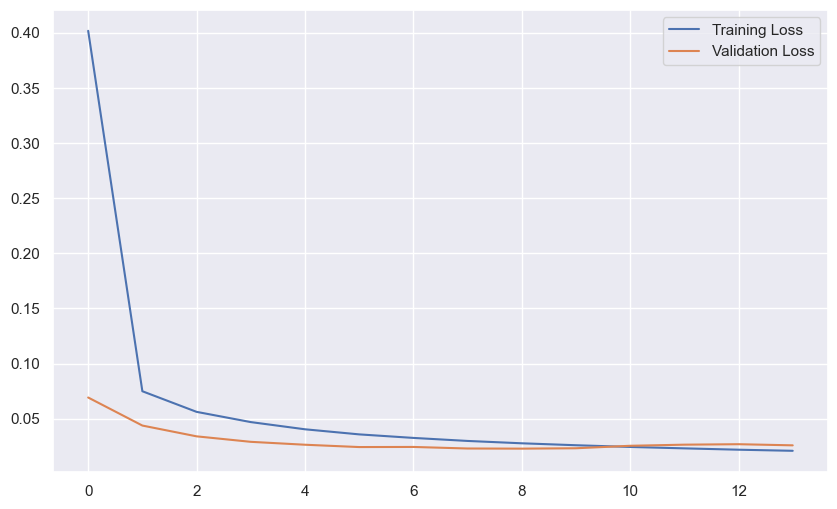

In [27]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.plot(history.history["loss"], label="Training Loss")
# 
ax.plot(history.history["val_loss"], label="Validation Loss")
# 
ax.legend();

In [28]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)

118/118 [==============================] - 0s 2ms/step


In [29]:
# Calculate loss...
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

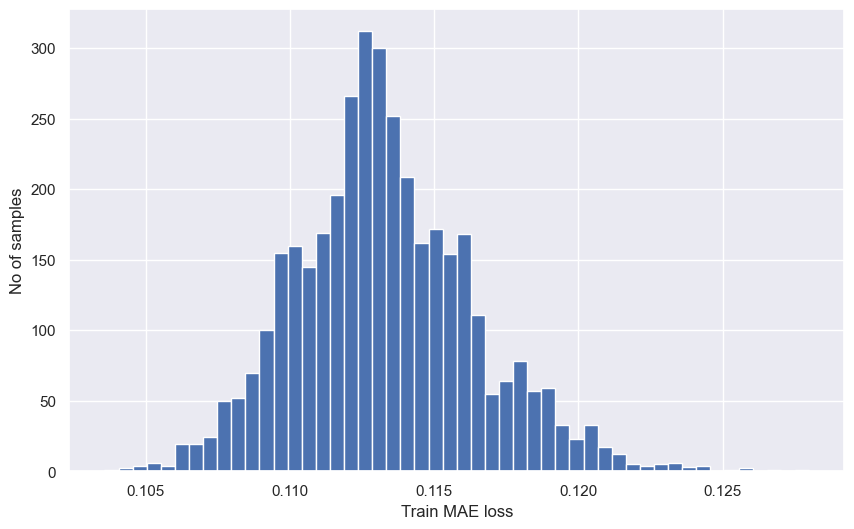

In [30]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.hist(train_mae_loss, bins=50)
# 
ax.set_xlabel("Train MAE loss")
#
ax.set_ylabel("No of samples");

In [31]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# 
threshold

0.12799598940887125

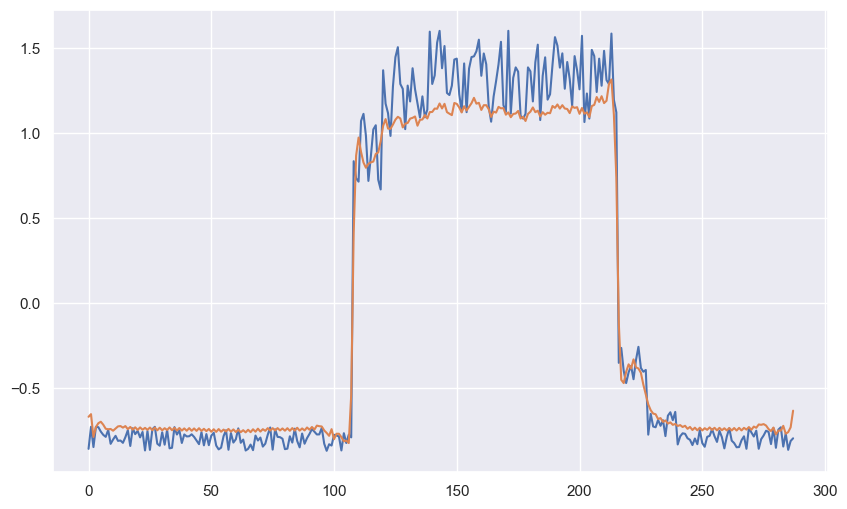

In [32]:

# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
ax.plot(x_train[0])

# 
ax.plot(x_train_pred[0]);

In [33]:

# 
df_test_value = (df_daily_jumpsup - train_mean) / train_std

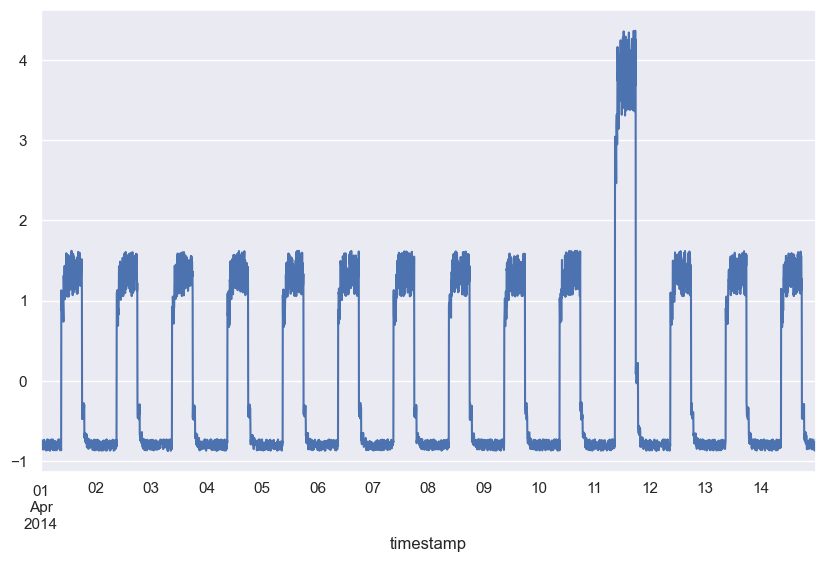

In [34]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_test_value.plot(legend=False, ax=ax);

In [37]:
# Create sequences from test values.
x_test = splitBySize(df_test_value.values)

x_test.shape

(3745, 288, 1)

In [38]:

# 
x_test_pred = model.predict(x_test)

118/118 [==============================] - 0s 2ms/step


In [39]:
# 
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

test_mae_loss

array([[0.1104363 ],
       [0.11580335],
       [0.11343887],
       ...,
       [0.11324338],
       [0.11515691],
       [0.11065814]])

In [40]:
# 
test_mae_loss = test_mae_loss.reshape((-1))

test_mae_loss

array([0.1104363 , 0.11580335, 0.11343887, ..., 0.11324338, 0.11515691,
       0.11065814])

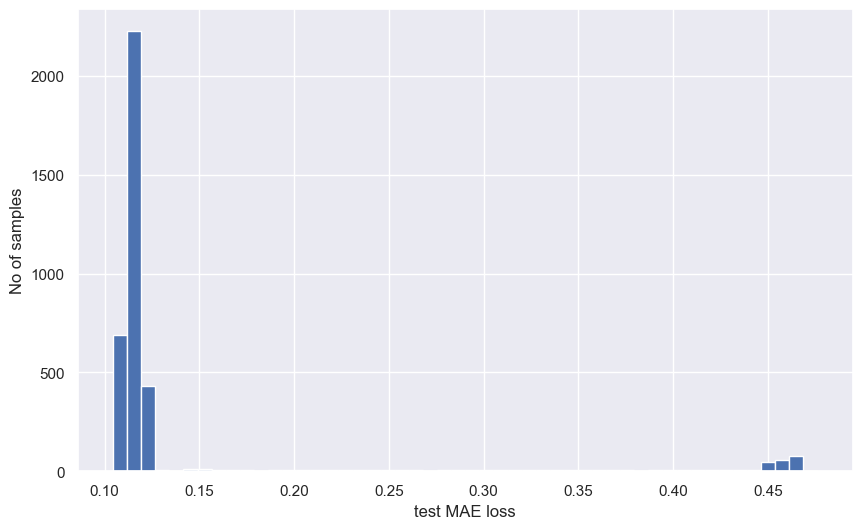

In [41]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

#
ax.hist(test_mae_loss, bins=50)

# 
ax.set_xlabel("test MAE loss")

# 
ax.set_ylabel("No of samples");

In [42]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# NUmber of anomalies.
np.sum(anomalies)

397

In [46]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(288 - 1, len(df_test_value) - 288 + 1):
    if np.all(anomalies[i - 288 + 1 : i]):
        inds.append(i)

In [47]:
# 
df_subset = df_daily_jumpsup.iloc[inds]

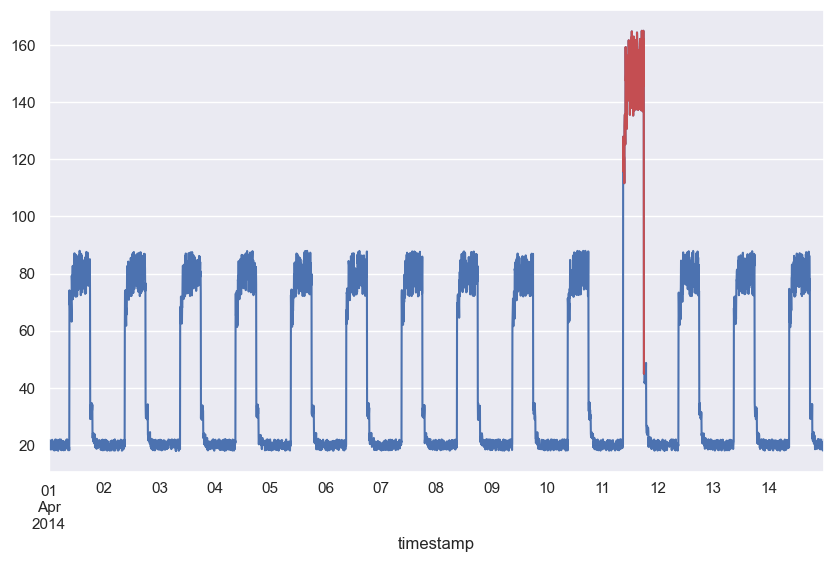

In [48]:
#
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_daily_jumpsup.plot(legend=False, ax=ax)

# 
df_subset.plot(legend=False, ax=ax, color="r");